# FingerPrint Verification using siamese networks:



## Loading neccessary packages and dataset:

We have all the neccesary files as .npy so let's mount the drive and load them to our CWD.

In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["image.cmap"] = 'binary'

import os, shutil, glob

Mount the Gogle drive:

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


Let's load the data from our google drive:

In [4]:
os.mkdir("./data")
for files in glob.glob(
    "/gdrive/My Drive/One Shot Learning/Finger print classification/*.npy"):
    shutil.copy(files, "./data/")

for i in glob.glob("./data/*"):
    print (i)

./data/features_data.npy
./data/image_data.npy


We have the following features in our dataset:

1. ID
2. Gender
3. Finger 
4. Type of image

Let's load the preprocessed numpy array to memory:

In [5]:
import numpy as np
images = np.load("./data/image_data.npy", allow_pickle=True)
features = np.load("./data/features_data.npy", allow_pickle=True)

images.shape, features.shape

((55270, 103, 96, 1), (55270, 5))

### Train-val Split:
The idea is to randomly take hide out the first 50 person's data as the validation dataset. We can implement this in the generator function ourself with ease. Jump to the triplet generator function definition.

## Let's create the network for the purpose of semi hard triplet generation:

In [0]:
def build_network(input_shape, embedding_size):
    '''Builds a conv net for the purpose of return similarity
    measures. The embedding size determines the output shape of nw'''

    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.InputLayer(input_shape=input_shape))

    model.add(tf.keras.layers.Conv2D(
        128, 5, activation='relu',
        kernel_initializer='he_uniform',
        kernel_regularizer=tf.keras.regularizers.l2(2e-4)))
    
    model.add(tf.keras.layers.MaxPooling2D())

    model.add(tf.keras.layers.Conv2D(
        128, 3, activation='relu', kernel_initializer='he_uniform',
        kernel_regularizer=tf.keras.regularizers.l2(2e-4)))

    model.add(tf.keras.layers.MaxPooling2D())
    
    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(
        512, activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(1e-3),
        kernel_initializer='he_uniform'))
        
    # output layer with embedding_size no of units
    model.add(tf.keras.layers.Dense(
        embedding_size, activation=None, kernel_regularizer=tf.keras.regularizers.l2(1e-3),
        kernel_initializer='he_uniform'))
    
    #Force the encoding to live on the d-dimentional hypershpere
    model.add(tf.keras.layers.Lambda(lambda x: tf.keras.backend.l2_normalize(x, axis=-1)))
    
    return model

## Let's now create the siamese network and the triplet loss layer to go with it:

In [0]:
class TripletLossLayer(tf.keras.layers.Layer):
    '''Layer that computes the triplet loss acc to formula.
    Formula: L = max(d(A,P)− d(A,N)+margin, 0)'''

    def __init__(self, alpha, **kwargs):
        super(TripletLossLayer, self).__init__(**kwargs)
        self.alpha = alpha

    def triplet_loss(self, inputs):
        anchor, positive, negative = inputs
        p_dist = tf.keras.backend.sum(tf.keras.backend.square(anchor-positive), axis=-1)
        n_dist = tf.keras.backend.sum(tf.keras.backend.square(anchor-negative), axis=-1)
        return tf.keras.backend.sum(tf.keras.backend.maximum(p_dist - n_dist + self.alpha, 0), axis=0)

    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        # parent's method
        self.add_loss(loss)
        return loss

    def get_config(self):
        '''To be able to save our model, we need to do this'''
        config = super().get_config().copy()
        config.update({'alpha': self.alpha,})
        return config

In [0]:
def build_siamese_net(input_shape, network, margin=0.2):
    '''
    Builds the siamese network
    Margin is the alpha value that would be passed to triplet loss layer.
    It exists to prevent the network from simply converging at 0 for any inputs
    that may be passed to it. Alpha ensures the model finds a better value to 
    satisify the triplet loss equation.
    '''

    # Define tensors for three input images
    anchor = tf.keras.layers.Input(input_shape, name="anchor_input")
    positive = tf.keras.layers.Input(input_shape, name="positive_input")
    negative = tf.keras.layers.Input(input_shape, name="negative_input")

    # connect the input tensors to three difference output embeddings
    anchor_embeddings = network(anchor)
    positive_embeddings = network(positive)
    negative_embeddings = network(negative)

    # create and add the triplet loss layer
    triplet_loss_layer = TripletLossLayer(alpha=margin)([anchor_embeddings, positive_embeddings, negative_embeddings])

    model = tf.keras.models.Model(
        inputs=[anchor, positive, negative],
        outputs=triplet_loss_layer)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr=0.00006),
        loss=None)
    
    return model

### Lets Create / Load the siamese net & the model with which we generate the batches:

In [9]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [10]:
with strategy.scope():
    # creating the models
    # model = build_network((103, 96, 1), 10)
    # siamese_net = build_siamese_net((103, 96, 1), model)

    # loading the models
    siamese_net = tf.keras.models.load_model("/gdrive/My Drive/One Shot Learning/Finger print classification/siamese_model")
    model = siamese_net.layers[3]

siamese_net.summary()
print ()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       [(None, 103, 96, 1)] 0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     [(None, 103, 96, 1)] 0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     [(None, 103, 96, 1)] 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 10)           33317770    anchor_input[0][0]               
                                                                 positive_input[0][0]         

### To access particular images based on the features we can do the following:

In [11]:
# slice images of left middle finger of person 100
images[np.all(features[:, [0, 2, 3]] == [b'100', b'Left', b'middle'], axis=1)].shape

(9, 103, 96, 1)

In [12]:
# slice every other image
images[~np.all(features[:, [0, 2, 3]] == [b'100', b'Left', b'middle'], axis=1)].shape

(55261, 103, 96, 1)

In [13]:
# using another array to slice the image array
filter_array = np.array([b'100', b'', b'Left', b'ring', b'Real'])
images[np.all(features[:, [0, 2, 3]] == filter_array[[0, 2, 3]], axis=1)].shape

(10, 103, 96, 1)

In [14]:
features[:, 0] == filter_array[0].ravel()

array([False, False, False, ..., False, False, False])

In [15]:
np.all(features[:, [2, 3]] == filter_array[[2, 3]], axis=1)

array([False, False, False, ..., False, False,  True])

In [16]:
# how many images for a hand finger combination?
hands_available = np.array([b"Right", b"Left"])
fingers_available = np.array([b"little", b"ring", b"middle", b"index", b"thumb"])

for combination in np.array(np.meshgrid(hands_available, fingers_available)).T.reshape(-1, 2):
    print (combination[0], combination[1], ":",
           images[np.all(features[:, [2, 3]] == combination, axis=1)].shape[0])

b'Right' b'little' : 5443
b'Right' b'ring' : 5486
b'Right' b'middle' : 5431
b'Right' b'index' : 5334
b'Right' b'thumb' : 5538
b'Left' b'little' : 5488
b'Left' b'ring' : 5612
b'Left' b'middle' : 5606
b'Left' b'index' : 5542
b'Left' b'thumb' : 5790


## Generating triplets using the network:

TRY WITH TF FUNCTIONS FOR OPTIMIZATION

In [17]:
# logic for combinations of array 2 at a time
a = images[: 5]
a, b = a[ None, :, None ], a[ :, None, None ]
cart = tf.concat([a + tf.zeros_like(b),
                                 tf.zeros_like(a) + b], axis=2)
cart = tf.reshape(cart, (-1 ,2, 103, 96, 1))
cart = cart[tf.map_fn(lambda x: tf.reduce_sum(x[0] - x[1]), cart) < 0]

'''
f, ax = plt.subplots(nrows=5, ncols=2, figsize=(15, 6))
for i, (img1, img2) in enumerate():
    ax[i][0].imshow(tf.reshape(img1, (103, 96)))
    ax[i][1].imshow(tf.reshape(img2, (103, 96)))
'''
cart.shape

TensorShape([10, 2, 103, 96, 1])

In [0]:
def generate_triplets(images, features, network, train=True, factor=4):
    '''
    Yields Anchor, Positive & negative image triplets
    
    images -> The image array
    features -> features array with indices same as images
    train -> boolean variable whether we want train or test
    factor -> greater the factor more tougher images can be sampled

    For a `ID`, `hand` and `finger`, it generates ~ID, hand and finger images
    randomly sampled and findns the top matching pairs to return as triplets
    '''

    hands_available = tf.constant([b"Right", b"Left"])
    fingers_available = tf.constant([b"little", b"ring", b"middle", b"index", b"thumb"])

    # loop forever yeilding numbers
    while True:

        # generate ID, Hand and Finger combinations to iterate over
        if train:
            total, offset = 550, 51
        else:
            total, offset = 50, 1

        #global anchor, positives, persons, hands, fingers, filter_array

        persons = tf.strings.as_string(tf.random.shuffle((tf.range(total) + offset)))
        hands = tf.gather(hands_available, tf.argsort(tf.random.uniform(shape=(total,))) // (total//len(hands_available)))
        fingers = tf.gather(fingers_available, tf.argsort(tf.random.uniform(shape=(total,))) // (total//len(fingers_available)))

        for person, hand, finger in zip(persons, hands, fingers):

            filter_array = np.array([person.numpy(), b'', hand.numpy(), finger.numpy(), b'Real'])

            anchor = images[tf.reduce_all(features[:, [0, 2, 3]] == filter_array[[0, 2, 3]], axis=1)]
            anchor = tf.random.shuffle(anchor)

            a, b = anchor[None, :, None], anchor[:, None, None]
            cart = tf.concat([a + tf.zeros_like(b), tf.zeros_like(a) + b], axis=2)
            temp = tf.reshape(cart, (-1 ,2, 103, 96, 1))
            temp = temp[tf.map_fn(lambda x: tf.reduce_sum(x[0] - x[1]), temp) < 0]

            anchor, positives = temp[:, 0], temp[:, 1]

            false = images[(tf.reduce_all(features[:, [2, 3]] == filter_array[[2, 3]], axis=1) & 
                        (features[:, 0] != filter_array[0].ravel()))]

            if train:
                false = tf.gather(
                    false, 
                    tf.argsort(tf.random.uniform(shape=(len(false),)))[:len(anchor)*factor]
                    )

                A = tf.repeat(network.predict(anchor), repeats=factor, axis=0)
                P = tf.repeat(network.predict(positives), repeats=factor, axis=0)
                N = network.predict(false)
            
                hard_batch_idx =  tf.argsort(
                    (tf.reduce_sum(tf.square(A - P), axis=1) - 
                    tf.reduce_sum(tf.square(A - N), axis=1)), 
                    direction='DESCENDING')[:len(anchor)]

                false = tf.gather(false, hard_batch_idx)
                anchor = tf.gather(anchor, hard_batch_idx // factor)
                positives = tf.gather(positives, hard_batch_idx // factor)
            
            else:
                false = tf.gather(
                    false, 
                    tf.argsort(tf.random.uniform(shape=(len(false),)))[:len(anchor)]
                    )

            for true, positive, negative in zip(anchor, positives, false):
                yield true, positive, negative
            

In [19]:
test = generate_triplets(images, features, model, train=True)
next(test)

(<tf.Tensor: shape=(103, 96, 1), dtype=float32, numpy=
 array([[[0.627451  ],
         [0.627451  ],
         [0.627451  ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],
 
        [[0.627451  ],
         [0.41176474],
         [0.41176474],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],
 
        [[0.627451  ],
         [0.41176474],
         [1.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],
 
        ...,
 
        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],
 
        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],
 
        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]]], d

### Let's create a generator dataset from the function we have created:

In [0]:
with strategy.scope():
    tf_dataset = tf.data.Dataset.from_generator(
        lambda: generate_triplets(images, features, model),
        output_types=(tf.float32, tf.float32, tf.float32),
        output_shapes=((103, 96, 1), (103, 96, 1), (103, 96, 1)))
    
    tf_val_dataset = tf.data.Dataset.from_generator(
        lambda: generate_triplets(images, features, model, False),
        output_types=(tf.float32, tf.float32, tf.float32),
        output_shapes=((103, 96, 1), (103, 96, 1), (103, 96, 1)))

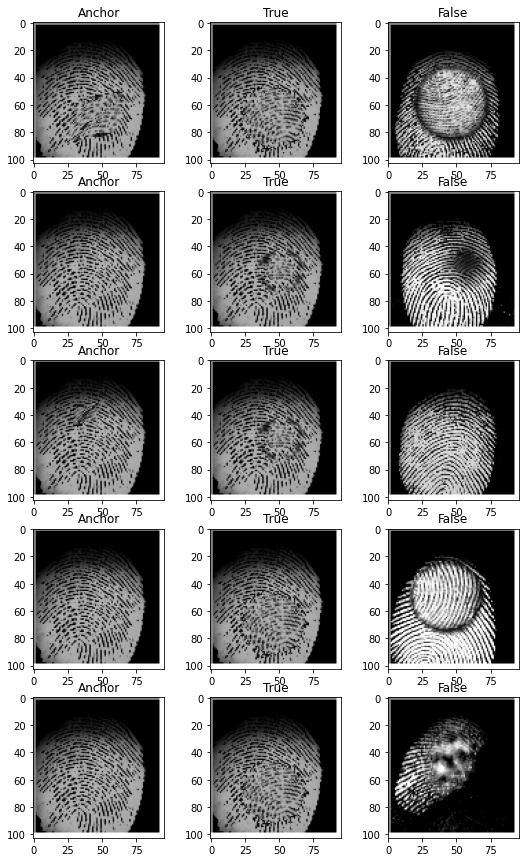

In [21]:
#@title Visualise train triplets
f, ax = plt.subplots(nrows=5, ncols=3, figsize=(9, 15))
for i, (original, positive, negative) in enumerate(tf_dataset.take(5)):
    ax[i][0].imshow(np.reshape(original, (103, 96)))
    ax[i][0].set_title("Anchor")
    ax[i][1].imshow(np.reshape(positive, (103, 96)))
    ax[i][1].set_title("True")
    ax[i][2].imshow(np.reshape(negative, (103, 96)))
    ax[i][2].set_title("False")

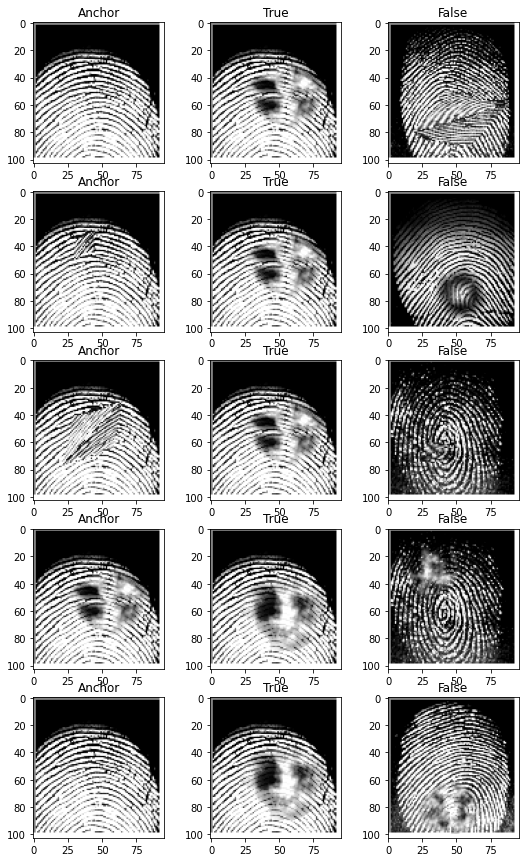

In [22]:
#@title Val dataset visualise triplets
f, ax = plt.subplots(nrows=5, ncols=3, figsize=(9, 15))
for i, (original, positive, negative) in enumerate(tf_val_dataset.take(5)):
    ax[i][0].imshow(np.reshape(original, (103, 96)))
    ax[i][0].set_title("Anchor")
    ax[i][1].imshow(np.reshape(positive, (103, 96)))
    ax[i][1].set_title("True")
    ax[i][2].imshow(np.reshape(negative, (103, 96)))
    ax[i][2].set_title("False")

## Let's make a function to create one shot tasks out of triplet batches and also write functions for visualising the task & evaluating them:

In [0]:
def make_one_shot_task(anchors, positives, negatives, batch_size=32):
    '''Given a triplet batch, it returns tuple of pairs and targets for the model
    to make predictions on. A binary task for the model'''
    
    #targets = np.random.randint(0, 2, batch_size)
    #pairs = np.stack((anchors, np.where(targets.reshape(batch_size, 1, 1, 1), positives, negatives)), axis=1)
    
    targets = tf.random.uniform((batch_size,)) > 0.5
    pairs = tf.stack((anchors, tf.where(tf.reshape(targets, (batch_size, 1, 1, 1)), positives, negatives)), axis=1)

    return pairs, targets

In [0]:
def visualise_task(pairs, targets, batch_size=32):
    '''Visualise the one shot tasks'''

    f, ax = plt.subplots(ncols=2, nrows=batch_size, figsize=(6, batch_size*3))
    for i, (pair, target) in enumerate(zip(pairs, targets)):
        
        ax[i][0].imshow(np.reshape(pair[0], (103, 96)))
        ax[i][0].set_title("Anchor")
        ax[i][0].axis("off")

        ax[i][1].imshow(np.reshape(pair[1], (103, 96)))
        ax[i][1].set_title("True" if target else "False")
        ax[i][1].axis("off")

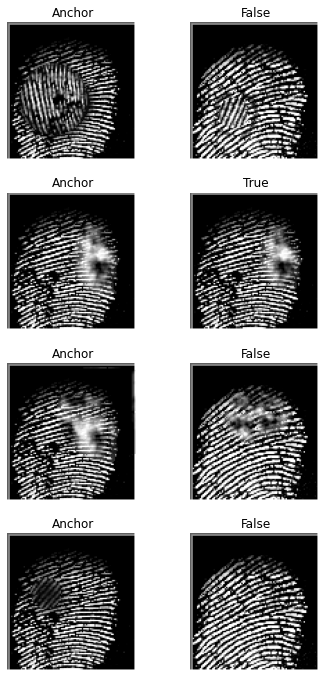

In [25]:
# sample test of the functions
pairs, targets = make_one_shot_task(*next(iter(tf_dataset.batch(4).take(1))), batch_size=4)
visualise_task(pairs, targets, 4)

In [0]:
def make_predictions(test_pairs, model, threshold=1e-1):
    '''Computes the distance between the embeddings and returns the distance'''    
    A = model.predict(test_pairs[:, 0])
    O = model.predict(test_pairs[:, 1])

    return tf.reduce_sum(tf.square(A - O), axis=1) < threshold

## Let's get to training!!!

In [0]:
evaluate_every = 500
BATCH_SIZE = 32
n_iter = 60000

with strategy.scope():
    train = tf_dataset.batch(BATCH_SIZE).prefetch(1)
    val = tf_val_dataset.batch(BATCH_SIZE).prefetch(1)

#### Let's evaluate our model performance before we train our model:

In [0]:
from sklearn.metrics import f1_score
anchors, positives, negatives = next(iter(tf_val_dataset.batch(1000).take(1)))
pairs, targets = make_one_shot_task(anchors, positives, negatives, batch_size=1000)
yprobs = make_predictions(pairs, model)
f1_score(targets, yprobs)

0.7725856697819315

In [0]:
import time

print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
best_score = 0
for i, input_ in enumerate(train.take(n_iter)):
    
    loss = siamese_net.train_on_batch(
        x=input_,
        y=None
        )

    if i % 25 == 0:
        print (".", end='')
    
    if i % evaluate_every == 0:

        anchors, positives, negatives = next(iter(val))
        pairs, targets = make_one_shot_task(anchors, positives, negatives, batch_size=BATCH_SIZE)
        yprobs = make_predictions(pairs, model)
        val_score = f1_score(targets, yprobs)

        print("\n ------------- \n")
        print("[{3}] Time for {0} iterations: {1:.1f} mins, Train Loss: {2}, Val score: {4}"
        .format(i, (time.time() - t_start) / 60.0, loss, i, val_score))

        if val_score >= best_score:
            best_score = val_score
            print ("Saving model...")
            siamese_net.save("/gdrive/My Drive/One Shot Learning/Finger print classification/siamese_model")

Starting training process!
-------------------------------------
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
.
 ------------- 

[0] Time for 0 iterations: 0.1 mins, Train Loss: 7.224264621734619, Val score: 0.8108108108108109
Saving model...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /gdrive/My Drive/One Shot Learning/Finger print classification/siamese_model/assets
....................
 ------------- 

[500

In [0]:
siamese_net.save("/gdrive/My Drive/One Shot Learning/Finger print classification/siamese_model")

INFO:tensorflow:Assets written to: /gdrive/My Drive/One Shot Learning/Finger print classification/siamese_model/assets


### Evaluate post training:

In [29]:
from sklearn.metrics import f1_score, precision_score 
anchors, positives, negatives = next(iter(tf_val_dataset.batch(2500).take(1)))
pairs, targets = make_one_shot_task(anchors, positives, negatives, batch_size=2500)
yprobs = make_predictions(pairs, model)
print ("F1 Score:", f1_score(targets, yprobs))
print ("Precision Score:", precision_score(targets, yprobs))

F1 Score: 0.9464812473662031
Precision Score: 1.0


Model has reached an impressive f1_score of 96, which could be improved by training for a longer duration or feeding the model with half random images as opposed to feeding it entirely with hard batch images.

### Let's visualise the distances between similar and different classes on the unseen dataset:

Person ID: b'33'
Hand: b'Right'
Finger: b'ring'


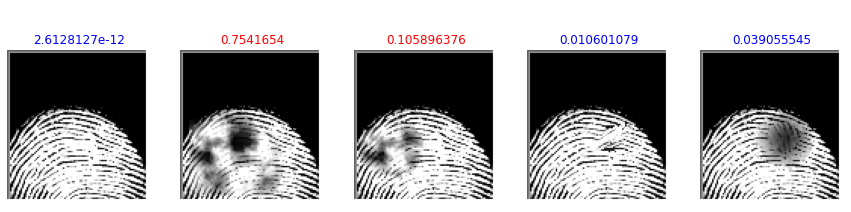

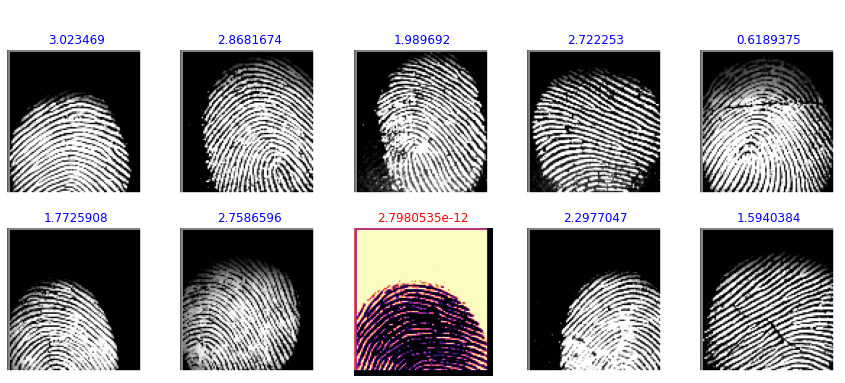

In [85]:
filter_feature = np.array(
    [str(np.random.randint(1, 51)).encode(), 
     np.random.choice([b'Left', b'Right']), 
     np.random.choice(fingers_available), 
     b'Real'
     ])

print (f"Person ID: {filter_feature[0]}\n\
Hand: {filter_feature[1]}\n\
Finger: {filter_feature[2]}")

same_temp = images[np.all(features[:, [0, 2, 3]] == filter_feature[:-1], axis=1)][:5]
diff_fingers = images[np.all(features[:, [0, 4]] == filter_feature[[0, 3]], axis=1)]
org = model.predict(np.expand_dims(same_temp[0], axis=0))
same = model.predict(same_temp)
diff = model.predict(diff_fingers)

y_probs_same = tf.reduce_sum(tf.square(org - same), axis=1).numpy()
y_probs_diff = tf.reduce_sum(tf.square(org - diff), axis=1).numpy()

f, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 3.5))
f.suptitle("Differences for same images; Average: " + str(y_probs_same.mean()), 
           color='white', size=15)

ax = ax.ravel()
for i, (img, y_prob) in enumerate(zip(same_temp, y_probs_same)):
    ax[i].imshow(img.reshape(103, 96))
    ax[i].set_title(str(y_prob), color=('b' if y_prob < 1e-1 else 'r'))
    ax[i].axis("off")

f, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
f.suptitle("Differences for diff images; Average: " + str(np.median(y_probs_diff)), 
           color='white', size=15)

ax = ax.ravel()
for i, (img, y_prob) in enumerate(zip(diff_fingers, y_probs_diff)):
    ax[i].imshow(img.reshape(103, 96), cmap='magma' if y_prob < 1e-1 else 'binary')
    ax[i].set_title(str(y_prob), color=('r' if y_prob < 1e-1 else 'b'))
    ax[i].axis("off")

Let's create a function that randomly choose a finger from the val dataset and compiles a list of images from which our model has to predict the matching image:

In [0]:
def create_test_batch(images, features, test_size=10):

    '''
    images -> the image numpy array containing the images
    features -> corresponding feature array
    test_size -> the number of images from which the model has to predict from

    Returns a tuple of original image, test_image_batch of 'test_size' and targets
    '''

    org_image_feature = np.array(
    [str(np.random.randint(1, 601)).encode(), 
     np.random.choice([b'Left', b'Right']), 
     np.random.choice(fingers_available),
     ])
    
    org_images = images[np.all(features[:, [0, 2, 3]] == org_image_feature, axis=1)]
    org_images = org_images[np.random.randint(len(org_images), size=2)]

    fake_images = images[~np.all(features[:, [0, 2, 3]] == org_image_feature, axis=1)]
    fake_images = fake_images[np.random.randint(len(fake_images), size=test_size-1)]

    test_image_batch = np.concatenate((fake_images, org_images[1][np.newaxis, :]))
    targets = np.concatenate((np.zeros(test_size-1), np.array([1])))
    shuffled_ids = np.random.permutation(test_size)
    test_image_batch, targets = test_image_batch[shuffled_ids], targets[shuffled_ids]

    return org_images[0][np.newaxis, :], test_image_batch, targets  

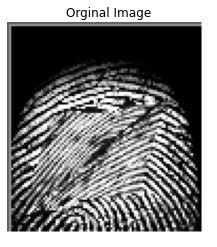

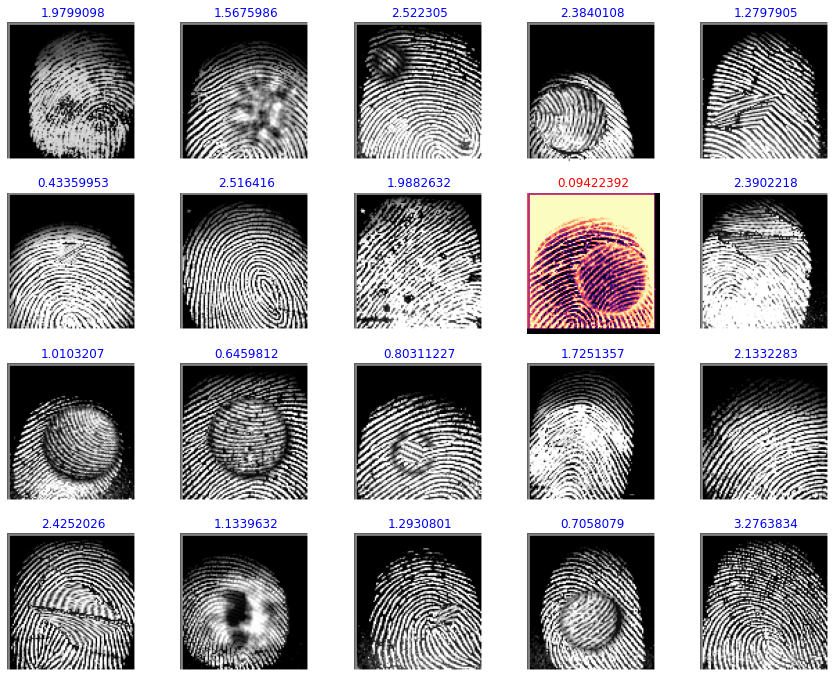

In [84]:
test_rows = 4
test_size = 5 * test_rows 
img, fake, targets = create_test_batch(images, features, test_size=test_size)
A = model.predict(img)
O = model.predict(fake)
distance = tf.reduce_sum(tf.square(A - O), axis=1).numpy()
pred = np.argmin(distance)

plt.imshow(img.reshape((103, 96)))
plt.title("Orginal Image")
plt.axis("off")

f, ax = plt.subplots(nrows=test_rows, ncols=5, figsize=(15, 3*test_rows))
ax = ax.ravel()

for i, (dist, img) in enumerate(zip(distance, fake)):
    ax[i].imshow(img.reshape((103, 96)), cmap='magma' if pred == i else 'binary')
    ax[i].set_title(dist, color='r' if targets[i] else 'b')
    ax[i].axis('off')